# Key findings thus far

## Iteration 0: The Default Case

Our starting accuracy on a hidden size of 256 and a sparsity penalty of 0.01 yielded a classifier accuracy (C_0) of 91.11%. The probe trained on the SAE targeting the first hidden layer had an accuracy of 91.40%, and the second SAE had an accuracy of 90.68%.

We then found the top 25 features, on average, per digit. We then constructed sparse vectors for each image in the training set based on the indices corresponding to the top 25 average activating features. This means that 25 sparse features, which on average should be impactful to the digit, were left the same as the sparse encoding value, and the rest of the sparse features were set to a value of 0. Reconstructing this provides our auxiliary loss label in `Iteration 1`.

## Iteration 1: First Auxiliary Loss Case

Here, we toyed with different loss functions, but settled of a weighted cosine distance (to 1. capture sparse feature directions and 2. gently adjust gradients during training). Toying with our loss factor, we found several interesting new settings as candidates to use for constructing new auxiliary loss targets.

First, was lambda = `0.011`, which was the best C_1 accuracy (92.85%) from the auxiliary loss case. However, the corresponding SAE probe accuracies (92.56% and 92.18%) were slightly worse at this loss factor. Additionally, we see that using this lambda value to generate new auxiliary targets yielded worse performance.

Thus, we hypothesized that not only does increased accuracy matter from a lambda target, but also if the SAE probes outperform the classifier. This is likely the key, because if the SAE probes are outperforming the classifier, it implies that our sparse features are better at identifiying the digit classes than our actual classifier. 

So, on this notion, we found two other promising lambdas, `0.006` and `0.017`. These both provided improvements on the original classifier, (92% and 92.16%, respectively), but more importantly, their SAE hidden layer one probe accuracies were better than the new classifier (92.29% and 92.72%, respectively).

## Iteration 2: "Ception begins!"

Training our original classifier with the sparse features generated by the `0.006` lambda has been promising thus far. Our best run has improved the classifier performance from Iteration 1 from 92.85% to 93.25%. Although, the SAE probes were not better than the classifier - they sit at 92.6% and 92.35% (althought this shows that we have likely improved from the best option at iteration 1, even if the path forward for improvement looks poor, as the features learned appear to be better).

The best classifer at iteration 2 has come from a higher loss factor of `0.02`. We stil need to gather more data across the board for loss factors at iteration 1 and performance at iteration 2. However, these are promising results, as it shows early evidence that we can continously "refine" features via an SAE, which simulataneously improves model performance and interpretability.

# Examine Loss Data

In [1]:
import pickle
import pandas as pd
import plotly.express as px

## Helpers

In [9]:
def load_loss_dict(file_path):
    with open(file_path, "rb") as f:
        loss_dict = pickle.load(f)

    return loss_dict

In [16]:
def create_df(merged_loss_dict):
    df = pd.DataFrame.from_dict(merged_loss_dict, orient="index").reset_index()
    df = df.rename(columns={'index': "Loss_Factor"})

    # for scaling
    df['S1_Probe_Acccuracy'] = df['S1_Probe_Acccuracy'] * 100
    df['S2_Probe_Acccuracy'] = df['S2_Probe_Acccuracy'] * 100

    df_long = pd.melt(
        df,
        id_vars=['Loss_Factor'],
        value_vars=['Final_Accuracy', 'S1_Probe_Acccuracy', 'S2_Probe_Acccuracy'],
        var_name='Metric',
        value_name='Value'
    )

    return df_long

In [20]:
def plot_loss_factors(df):
    fig = px.line(
        df,
        x='Loss_Factor',
        y='Value',
        color='Metric',
        title='Accuracy Metrics vs. Dictionary Keys',
        labels={'Loss_Factor': 'Loss_Factors', 'Value': 'Accuracy', 'Metric': 'Metric'},
        markers=True  # Add markers to the lines
    )
    
    # Update layout for better visualization
    fig.update_layout(
        yaxis=dict(range=[min(df['Value']) - 5, max(100, max(df['Value']) + 5)]),
        xaxis=dict(tickmode='linear'),  # Adjust if keys are non-numerical
        showlegend=True
    )
    
    # Show the plot
    fig.show()

In [39]:
def main(loss_dict_paths):
    loss_dict_iter = {}
    for path in loss_dict_paths:
        temp_d = load_loss_dict(path)
        loss_dict_iter = loss_dict_iter | temp_d
    
    df = create_df(loss_dict_iter)
    plot_loss_factors(df)

# Iteration 0

We skip over this for now, as our only settings would be to change hidden size and loss penalty. This is not as critical to our research.

# Iteration 1

Again, we can only have one "branch" to explore here. Everything from our original classifier and SAEs with a hidden size of `256` and loss penalty of `0.01`. I guess the other factor here is that we choose `N = 25` sparse features for a "sharpened" reconstructed hidden activation target during auxiliary loss.

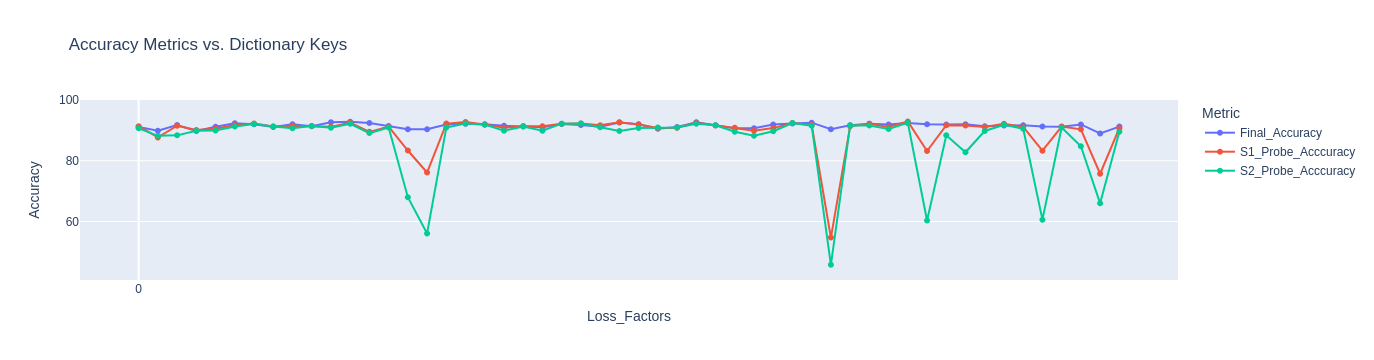

In [44]:
loss_dict_paths = ["./loss_data_dict_0.0_to_0.01.pkl", "./loss_data_dict_0.011_to_0.051.pkl"]
main(loss_dict_paths)

# Iteration 2

## Lambda = 0.011

This was the best classifier accuracy.

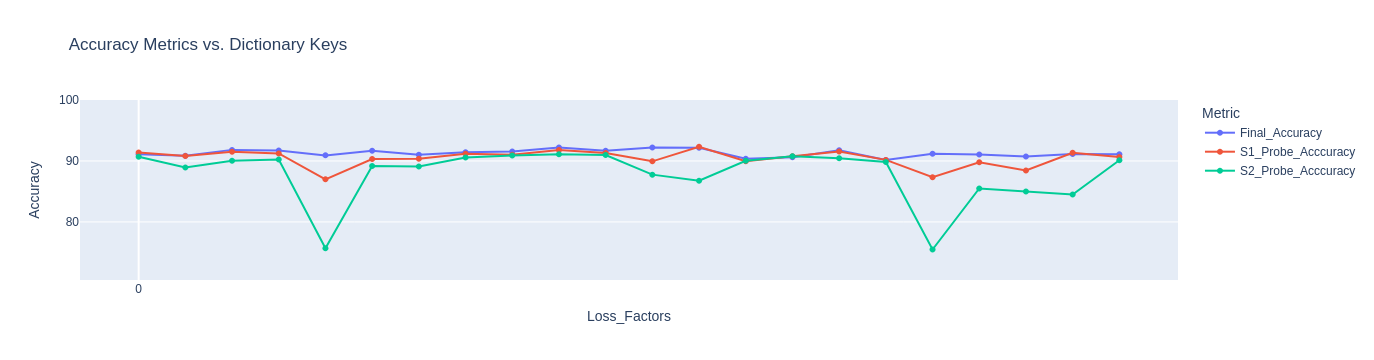

In [41]:
loss_dict_paths = [
    "./v2_loss_data_dict_0.0_to_0.004.pkl",
    "./v2_loss_data_dict_0.005_to_0.012.pkl",
    "./v2_loss_data_dict_0.013_to_0.02.pkl"
]
main(loss_dict_paths)

## Lambda = 0.006

This was a good lambda candidate since classifier accuracy improved and SAE performance was better than the improved classifier.

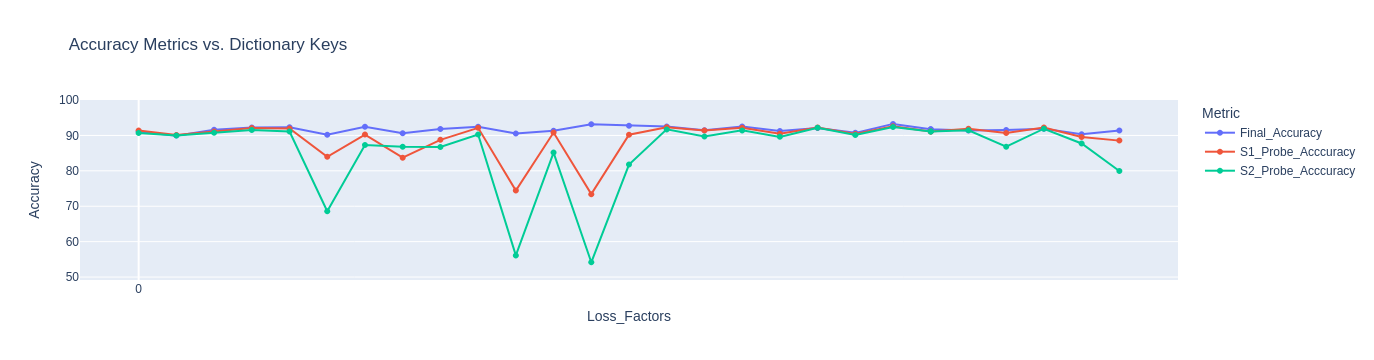

In [42]:
loss_dict_paths = [
    "./v2-1_loss_data_dict_0.0_to_0.004.pkl",
    "./v2-1_loss_data_dict_0.005_to_0.012.pkl",
    "./v2-1_loss_data_dict_0.013_to_0.02.pkl",
    "./v2-1_loss_data_dict_0.021_to_0.026.pkl"
]
main(loss_dict_paths)

## Lambda = 0.017

Another strong candidate as classifier accuracy improved, along with better SAE performance.

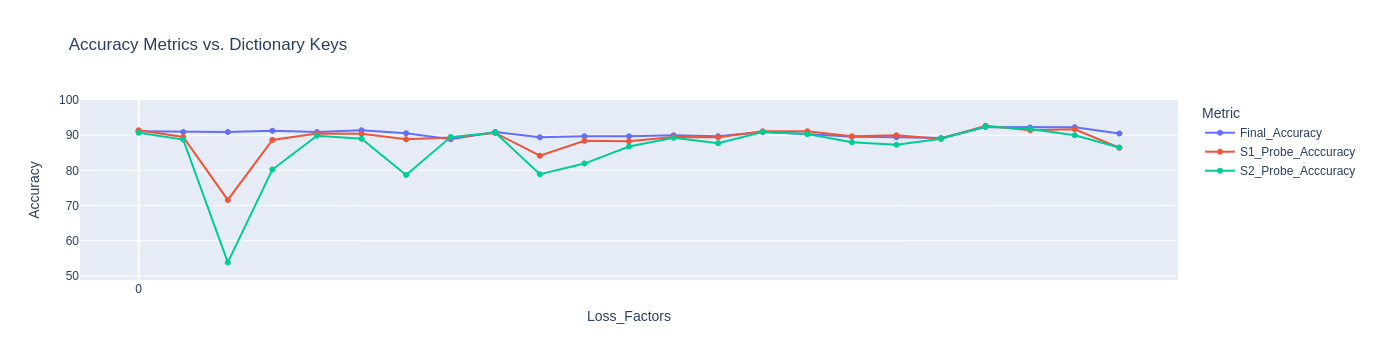

In [43]:
loss_dict_paths = [
    "./v2-2_loss_data_dict_0.0_to_0.01.pkl",
    "./v2-2_loss_data_dict_0.011_to_0.021.pkl",
]
main(loss_dict_paths)